In [ ]:
#getting assigned dataset
!git clone https://github.com/Earnings-Call-Dataset/MAEC-A-Multimodal-Aligned-Earnings-Conference-Call-Dataset-for-Financial-Risk-Prediction.git

fatal: destination path 'MAEC-A-Multimodal-Aligned-Earnings-Conference-Call-Dataset-for-Financial-Risk-Prediction' already exists and is not an empty directory.


In [ ]:
!pip install tqdm
!pip install tensorflow_hub
!pip install bert-for-tf2

In [ ]:
#general libraries
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import tensorflow as tf
import tensorflow_hub as tf_hub
import keras

import datetime
import math
import pandas as pd
import pandas_datareader.data as web
from pandas import Series, DataFrame
from tqdm import tqdm

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

%matplotlib inline

In [ ]:
#BERT dependencies
# REFERENCE https://pypi.org/project/bert-for-tf2/0.2.0/
import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, load_stock_weights
from bert.loader import map_stock_config_to_params
FullTokenizer = bert.bert_tokenization.FullTokenizer

In [ ]:
# downloading BERT model available online
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
!unzip uncased_L-12_H-768_A-12.zip


--2021-01-11 06:03:49--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.183.128, 173.194.197.128, 173.194.192.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.183.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip.2’

uncased_L-12_H-768_ 100%[===================>] 388.84M   106MB/s    in 3.7s    

2021-01-11 06:03:53 (106 MB/s) - ‘uncased_L-12_H-768_A-12.zip.2’ saved [407727028/407727028]

Archive:  uncased_L-12_H-768_A-12.zip
replace uncased_L-12_H-768_A-12/bert_model.ckpt.meta? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
replace uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001

In [ ]:

# making required directories as per documentation
# REF https://pypi.org/project/bert-for-tf2/0.2.0/
os.makedirs("models", exist_ok=True)
!mv uncased_L-12_H-768_A-12/ models

mv: cannot move 'uncased_L-12_H-768_A-12/' to 'models/uncased_L-12_H-768_A-12': Directory not empty


In [ ]:
model_dir = "models/uncased_L-12_H-768_A-12"

bert_config_file = os.path.join(model_dir, "bert_config.json")
bert_ckpt_file = os.path.join(model_dir, "bert_model.ckpt")
tokenizer = FullTokenizer(vocab_file=os.path.join(model_dir, "vocab.txt"))

# Calculating true target value from Yahoo Finance
## i.e., Stock volatility over next 𝜏=3 days after earning call. Definition according in eq1 in [1]

In [ ]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
#folder name example : 20150225_LMAT format : YYYYMMDD_{COMPANY_CODE}
#ref:- https://www.learndatasci.com/tutorials/python-finance-part-yahoo-finance-api-pandas-matplotlib/
#ref:- https://stackoverflow.com/questions/50348141/what-is-the-quickest-way-to-increment-date-string-yyyy-mm-dd-in-python

def stock_volatility_next3(folder_name):
  date = folder_name.split('_')[0]
  comp_code = folder_name.split('_')[1]

  year = date[:4]
  month = date[4:6]
  day = date[6:8]

  start_date = year + "-" + month + "-" + day
  end_date = (pd.Timestamp(start_date) + pd.DateOffset(days=7)).strftime('%Y-%m-%d')
  # +6 to account for holidays and weekends

  panel_data = data.DataReader(comp_code, 'yahoo', start_date, end_date)
  close = panel_data['Close']
  all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')
  close = close.reindex(all_weekdays)
  close = close.fillna(method='ffill') # with with last available price in case absent

  close = close.head(5) # first 5 needed for 4 return prices.
  a = np.std([float(close[1]/close[0]) - 1, float(close[2]/close[1]) - 1, float(close[3]/close[2]) - 1, float(close[4]/close[3]) - 1], ddof=1)  # IMP
  return np.log(a)



In [ ]:
print(stock_volatility_next3("20160817_A"))

-3.7654123158952135


## Creating Final SMALL Dataset (100 + 20)

In [ ]:
from sklearn.preprocessing import StandardScaler

def readfile(foldername):

  date = foldername.split('_')[0]
  comp_code = foldername.split('_')[1]
  local_dir = '/content/MAEC-A-Multimodal-Aligned-Earnings-Conference-Call-Dataset-for-Financial-Risk-Prediction/MAEC_Dataset/'
  df = pd.DataFrame(pd.read_csv(local_dir + date + "_" + comp_code + "/" + 'features.csv') )
  df = df.replace(	'--undefined-- ' , np.nan)
  df = df.replace(	'--undefined--' , np.nan)
  df = df.replace(	'--undefined-' , np.nan)
  df = df.fillna(method='ffill')
  df= pd.DataFrame(df , dtype='float')
  # print(df.shape)
  audio = df.to_numpy()
  audio = np.matrix.round(audio, decimals=3)
  audio = np.nan_to_num(audio)
  audio = StandardScaler().fit_transform(audio)
  df1= pd.DataFrame(audio , dtype='float')
  df1 = df1.fillna(method='bfill')
  df1 = df1.replace(	np.nan , 0)

  # print(audio.shape)
  return open(local_dir + date + "_" + comp_code + "/" + 'text.txt').read() , df1

In [ ]:
local_dir = '/content/MAEC-A-Multimodal-Aligned-Earnings-Conference-Call-Dataset-for-Financial-Risk-Prediction/MAEC_Dataset/'
folder_names = os.listdir(local_dir)
f_names = pd.DataFrame(folder_names)
readfile("20150225_LMAT")

("Thank you, Whitley.\nGood afternoon and thank you for joining us on our Q4 2014 conference call.\nJoining me on today's call is our Chairman and CEO <UNK> <UNK> and our President <UNK> <UNK>.\nBefore we begin, I will read our Safe Harbor statement.\nToday we will make some forward-looking statements, the accuracy of which is subject to risks and uncertainties.\nWherever possible, we will try to identify those forward-looking statements by using words such as believe, expect, anticipate, forecast, and similar expressions.\nOur forward-looking statements are based on our estimates and assumptions as of today, February 25, 2015, and should not be relied upon as representing our estimates or views on any subsequent date.\nPlease refer to the cautionary statement regarding forward-looking information and the risk factors in our most recent 10-K and subsequent SEC filings, including disclosure of the factors that could cause results to differ materially from those expressed or implied.\nDu

In [ ]:
textarr = []
# audioarr=
max_clip_length = 0
for itr in range(120):
  text, _ = readfile(f_names[0][itr])
  # max_clip_length = max(max_clip_length , audio.shape[0])
  # audio = audio.to_numpy()
  # audio = np.matrix.round(audio, decimals=3)
  textarr.append(text)
  # audioarr.append(audio)

smallds = pd.DataFrame(f_names[0][:120])
smallds['text'] = textarr
smallds['audio'] = ''
# smallds['audio'] = audioarr

for itr in range(120):
  _, audio = readfile(f_names[0][itr])
  max_clip_length = max(max_clip_length , audio.shape[0])
  # audio = audio.to_numpy()
  # audio = np.matrix.round(audio, decimals=3)
  # textarr.append(text)
  smallds['audio'][itr] = audio


# print(audioarr.shape)
print(audio)
# print(type(smallds['audio'][0]))


# smallds = pd.DataFrame(f_names[0][:120])
# smallds['text'] = textarr
# smallds['audio'] = audioarr

# print(type(smallds['audio'][500]))
smallds.set_index(0) # for removing folder with errors
smallds.head()
print(max_clip_length)

          0         1         2   ...        26        27        28
0  -1.346129 -1.397636  0.659777  ... -0.535406  0.381517 -0.725345
1   0.769223  0.048554 -0.516999  ... -0.302480  0.137543  2.152501
2   0.825673  0.692304  0.030770  ...  1.240654 -1.432864  0.229454
3   1.396477  1.318501  0.458218  ...  0.803918 -0.468186  0.384105
4   0.142105 -1.568986  0.217392  ...  0.061467  0.076970 -0.254669
..       ...       ...       ...  ...       ...       ...       ...
67 -0.543724 -0.424120 -0.773083  ... -0.739216  0.815623  0.673234
68  3.437160  0.424590  4.581539  ... -0.841121  1.184108 -1.081714
69  0.366283  0.152594  0.360898  ... -1.627246  2.033810 -0.301737
70  0.561342  0.935431 -0.717642  ... -0.200575  0.398904  1.338905
71 -2.043261 -2.035759  0.360531  ... -0.549964 -0.539976 -1.330500

[72 rows x 29 columns]
409


In [ ]:
smallds.head()

,0,text,audio
0,20160128_AN,Our CFS gross profits definitely are strong an...,0 1 2 ... ...
1,20150501_CTB,"First of all, <UNK>, that's exactly what we're...",0 1 2 ... 2...
2,20150723_CSL,"Yes, I think Matt, right now, we expect it to ...",0 1 2 ... 2...
3,20151028_NTRI,"Well, the way the retail business works is the...",0 1 2 ... 26...
4,20161019_HWC,Thank you and good morning.\nDuring today's ca...,0 1 2 ... ...


### Target value column calculation

In [ ]:
true_label = []
index_error = []

for itr in range(120):
  try:
    true_label.append(stock_volatility_next3(f_names[0][itr]))
  except:
    index_error.append(itr)



In [ ]:
# print(smallds['20151028_NTRI'])

for itr in index_error:
  smallds.drop(itr, inplace=True)



In [ ]:

true_label = np.nan_to_num(true_label)
smallds['Volatility'] = true_label
print(smallds.head())
print(smallds.shape)


               0  ... Volatility
0    20160128_AN  ...  -3.275622
1   20150501_CTB  ...  -3.670541
2   20150723_CSL  ...  -4.546330
4   20161019_HWC  ...  -4.882452
5  20160728_INVA  ...  -2.995828

[5 rows x 4 columns]
(110, 4)


In [ ]:
smallds.head()
smallds.audio[1]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28
0,-0.531721,0.282651,-0.585551,0.473890,-0.711658,-1.142501,-0.277316,0.833915,0.852134,0.297515,0.697207,-0.679078,0.783732,0.239774,-0.326296,0.0,-0.295979,-0.162756,-0.295426,0.667506,0.390938,0.980549,0.716656,-0.410536,0.980503,-0.042355,-0.031538,-0.122218,0.812013
1,-0.337761,0.644493,-0.577733,0.952512,-0.712727,-0.961190,0.004783,0.645997,0.640591,0.297515,0.697207,-0.655286,0.630447,-0.011032,-0.148837,0.0,-0.119885,0.096714,-0.119316,0.570626,0.846584,-0.132930,0.347947,0.137323,-0.132754,0.342493,-0.470019,0.153962,0.479954
2,0.100641,1.219109,-0.244866,0.627475,-0.729194,0.072890,-1.700059,0.387960,0.333703,-0.540936,0.697207,0.203841,0.247234,0.355625,-0.139023,0.0,-0.061660,0.083002,-0.061559,0.697572,0.340928,0.181389,-0.910860,-0.658500,0.181562,0.591513,-0.707035,0.456957,0.283894
3,-0.218036,0.661210,-0.448209,0.641333,-0.697116,-0.900897,-0.112992,0.514174,0.536308,0.297515,0.697207,-1.032110,0.017306,-0.847078,-0.457959,0.0,-0.463553,-0.333626,-0.463015,0.109614,0.118662,-0.142474,-0.059744,-0.493319,-0.142298,1.021638,-1.050709,0.967757,0.102850
4,-0.308035,0.234130,-0.608168,0.455056,-0.845106,-1.425745,0.157382,0.037366,0.062569,0.297515,0.697207,-0.819266,-0.135979,0.030701,-0.447328,0.0,-0.443671,-0.227096,-0.444079,-0.158383,0.096435,-0.425616,-0.098727,0.177406,-0.425650,0.568875,-0.552974,0.477737,-0.168573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,-0.715655,-0.883541,-0.094773,0.432047,1.393348,1.036412,-0.003880,0.281380,0.271134,1.135965,-0.411173,0.138791,1.090302,1.275793,-1.126907,0.0,-1.200592,-1.013943,-1.201069,-0.930820,-1.192711,-0.557325,-0.477452,-0.541866,-0.557358,0.455684,-0.552974,0.361098,0.827028
58,-0.751135,-0.767104,-0.264812,0.523917,1.139499,0.805508,1.800886,0.073828,0.092364,1.135965,-0.411173,0.073214,0.017306,0.126957,-0.983794,0.0,-0.993256,-0.786116,-0.993240,-1.272311,-1.164927,-1.180873,-0.772256,-0.442465,-1.180689,0.116112,-0.067091,0.202227,0.555606
59,-0.409280,-0.344842,0.043407,0.305454,1.450876,0.889657,0.437468,-0.431026,-0.411170,0.297515,-0.411173,0.150085,-0.442549,0.799024,-0.610067,0.0,-0.521778,-0.463361,-0.522192,-0.905579,-0.575921,-0.362625,-0.508313,-0.610492,-0.362659,-0.517756,0.703212,-0.337398,-0.289269
60,-0.397287,0.190426,-0.005265,0.694611,1.029896,0.908309,1.034915,0.940495,0.914704,0.297515,0.697207,0.756390,1.626800,2.047231,-0.469408,0.0,-0.355624,-0.469689,-0.355550,-0.434173,-0.653714,-0.142474,-0.381078,-0.402535,-0.142510,-0.653585,0.750615,-0.512357,1.882977


In [ ]:
smallds.to_csv("smallds.csv")

##Using the small final dataset

In [ ]:
# smallds = pd.read_csv("smallds.csv")
labels = smallds['Volatility']

In [ ]:
smallds.head()

,0,text,audio,Volatility
0,20160128_AN,Our CFS gross profits definitely are strong an...,0 1 2 ... ...,-3.275622
1,20150501_CTB,"First of all, <UNK>, that's exactly what we're...",0 1 2 ... 2...,-3.670541
2,20150723_CSL,"Yes, I think Matt, right now, we expect it to ...",0 1 2 ... 2...,-4.546330
4,20161019_HWC,Thank you and good morning.\nDuring today's ca...,0 1 2 ... ...,-4.882452
5,20160728_INVA,"Good afternoon, everyone, and thank you for jo...",0 1 2 ... ...,-2.995828


In [ ]:
#ref:- https://pypi.org/project/bert-for-tf2/0.2.0/
# REF:- https://towardsdatascience.com/simple-bert-using-tensorflow-2-0-132cb19e9b22
transcripts = smallds['text']
max_seq_len = 0
tokenized_transcripts = []

for transcript in transcripts:
  tokens = tokenizer.tokenize(transcript)
  tokens = ["[CLS]"] + tokens + ["[SEP]"]
  token_ids = tokenizer.convert_tokens_to_ids(tokens)
  max_seq_len = max(max_seq_len , len(token_ids))
  tokenized_transcripts.append(token_ids)





In [ ]:
from keras.preprocessing.sequence import pad_sequences
MAX_SEQ_LEN = 128
padded_text = pad_sequences(tokenized_transcripts, maxlen=min(MAX_SEQ_LEN , max_seq_len), padding="post")



In [ ]:
print(padded_text[:50])
print(max_seq_len)
print(len(padded_text[0]))

[[ 2029  2003  2037 ...  2651  1012   102]
 [ 2006 14972  2256 ...  2172  1012   102]
 [ 2454  1998  4880 ...  2255  1012   102]
 ...
 [16095  3775  6774 ...  5353  1012   102]
 [ 2008  2200  3160 ...  5353  1012   102]
 [ 2013  6522  2000 ...  2017  1012   102]]
9683
128


In [ ]:
print(smallds['audio'].shape)

(110,)


In [ ]:
# padding audio features of a earning call to max_clip_length

# audios = smallds['audio']
print(smallds['audio'][99])
# concat_audios = []
print(len(smallds['audio']))

smallds['audio'] = [audio.reindex(range(max_clip_length), fill_value=0) for audio in smallds['audio']]

# for a, row in tqdm(smallds.iterrows()):
#   smallds['audio'][a] = row['audio'].to_numpy().flatten()

  # concat_audios.append(audioflt)

print(smallds['audio'][5].shape)

# print(concat_audios[:5])
# concat_audios = np.asarray(concat_audios)
# print(concat_audios.shape)

# concat_audios = concat_audios.reshape(110,-1,29)
# concat_audios.shape

           0         1         2   ...        26        27        28
0   -0.365378 -0.804403 -0.109889  ... -1.483829  2.050262  0.562891
1   -0.405472 -0.670334  0.762672  ... -0.642224  0.513435 -0.745238
2   -0.487231 -0.319936 -0.866515  ... -0.471463  0.347051 -0.716551
3   -0.709443 -0.382187 -0.577572  ...  0.260368 -0.307345 -0.728026
4   -1.087476 -1.220801  0.166356  ... -1.203294  1.341643 -0.768188
..        ...       ...       ...  ...       ...       ...       ...
96  -0.734140  0.137516 -0.078717  ... -0.776393  0.313625 -1.204230
97  -1.591633 -2.205737  0.189002  ...  0.821438 -1.515117 -0.888673
98  -0.337001 -0.190314  0.623724  ...  1.175156 -0.961740 -0.871461
99   0.140520  0.631781 -0.440228  ...  2.028959 -1.726068 -0.768188
100  2.521861  2.515359  0.910284  ...  1.785015 -1.614650 -1.273079

[101 rows x 29 columns]
110
(409, 29)


##MODEL

In [ ]:
# REF: -https://colab.research.google.com/github/dipanjanS/nlp_workshop_odsc19/blob/master/Module05%20-%20NLP%20Applications/Project07E%20-%20Text%20Classification%20with%20BERT%20Deep%20Transfer%20Learning.ipynb#scrollTo=cXGxumq_Z6JT
# REF:- https://towardsdatascience.com/simple-bert-using-tensorflow-2-0-132cb19e9b22
# REF:- https://www.kdnuggets.com/2020/02/intent-recognition-bert-keras-tensorflow.html
from tensorflow.keras import layers


def create_model(max_seq_len, bert_ckpt_file):

    with tf.io.gfile.GFile(bert_config_file, "r") as reader:
        bc = StockBertConfig.from_json_string(reader.read())
        bert_params = map_stock_config_to_params(bc)
        bert_params.adapter_size = None
        bert = BertModelLayer.from_params(bert_params, name="bert")


    input_1 = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="text")
    bert_output = bert(input_1)
    cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output) # from reference
    cls_out = keras.layers.Dropout(0.5)(cls_out)

    hidden_1_1 = keras.layers.Dense(units=256, activation="relu")(cls_out) # from ref taken 768 bert outout
    hidden_1_1 = keras.layers.LeakyReLU(alpha=0.15)(hidden_1_1)
    hidden_1_2 = keras.layers.Dropout(0.15)(hidden_1_1)

    input_2 = keras.layers.Input(shape=(None,29), name = "audio")
    lstm_output = layers.Bidirectional(layers.LSTM(64))(input_2)
    hidden_2_1 = keras.layers.Dropout(0.15)(lstm_output)
    hidden_2_2 = keras.layers.Dense(256)(hidden_2_1)
    hidden_2_2 = keras.layers.LeakyReLU(alpha=0.15)(hidden_2_2)
    hidden_2_3 = keras.layers.Dropout(0.15)(hidden_2_2)

    concat = keras.layers.Concatenate(axis=1)([hidden_1_2, hidden_2_3])

    hidden_1 = keras.layers.Dense(units=128)(concat) # from ref taken 768 bert outout
    hidden_1 = keras.layers.LeakyReLU(alpha=0.15)(hidden_1)
    hidden_2 = keras.layers.Dropout(0.15)(hidden_1)

    # hidden_3 = keras.layers.Dense(units=512, activation="relu")(hidden_2)
    # hidden_4 = keras.layers.Dropout(0.15)(hidden_3)
    #computational constraints

    hidden_5 = keras.layers.Dense(units=64)(hidden_2)
    hidden_5 = keras.layers.LeakyReLU(alpha=0.15)(hidden_5)
    hidden_6 = keras.layers.Dropout(0.15)(hidden_5)

    output_1 = keras.layers.Dense(units=1)(hidden_6)

    model = keras.Model(inputs=[input_1,input_2], outputs=output_1)
    # model.build(input_shape=(None, max_seq_len))

    load_stock_weights(bert, bert_ckpt_file)
    return model



In [ ]:
model = create_model(MAX_SEQ_LEN , bert_ckpt_file)

Done loading 196 BERT weights from: models/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fe7b4402320> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [ ]:
model.compile(loss="mse", optimizer="adam", metrics='mse')
#  metrics=["accuracy", tf.keras.metrics.MeanSquaredError()]

In [ ]:
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None, 128)]        0                                            
__________________________________________________________________________________________________
bert (BertModelLayer)           (None, 128, 768)     108890112   text[0][0]                       
__________________________________________________________________________________________________
audio (InputLayer)              [(None, None, 29)]   0                                            
__________________________________________________________________________________________________
lambda_19 (Lambda)              (None, 768)          0           bert[0][0]                       
___________________________________________________________________________________________

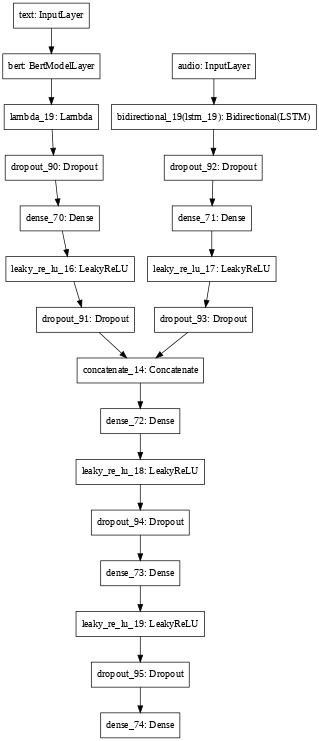

In [ ]:
tf.keras.utils.plot_model(model, to_file='sum_model.png',dpi=50)

In [ ]:
from keras.callbacks import LambdaCallback, ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint(
    filepath="model_best.hdf5",
    monitor="mse",
    verbose=1,
    save_best_only=True,
    mode="min",
)

In [ ]:
es = EarlyStopping(monitor='mse', mode='min', verbose=1, patience=4)

In [ ]:
print(smallds['audio'][1].shape)
print(type(padded_text[1]))
smallds['audio'] = [np.array(audio).astype('float32') for audio in smallds['audio']]

print(type(smallds['audio'][1]))

(409, 29)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:

audioarr = [audio for audio in smallds['audio']]
audioarr_1 = np.asarray(audioarr)
audioarr_1.shape


(110, 409, 29)

In [ ]:

audioarr_train = audioarr_1[:80,:,:]
audioarr_test = audioarr_1[80:,:,:]
audioarr_test.shape

(30, 409, 29)

In [ ]:
print(smallds['Volatility'][:80].shape)
print(smallds['Volatility'][:80])
# smallds['Volatility'] = smallds['Volatility'].fillna(method='bfill')

(80,)
0    -3.275622
1    -3.670541
2    -4.546330
4    -4.882452
5    -2.995828
        ...   
82   -4.616267
83   -4.168243
84   -3.639561
85   -4.118037
86   -4.157920
Name: Volatility, Length: 80, dtype: float64


In [ ]:
label = np.asarray(smallds['Volatility'])
# labels = StandardScaler().fit_transform(label)
# labels = (labels - np.mean(labels)) / np.std(labels)
# label = pd.DataFrame(labels)
# label = label.fillna(method='bfill')

label_train = label[:80]
label_test  = label[80:]
print(label_train.shape)


(80,)


In [ ]:
print(label_train)

[-3.27562228 -3.67054133 -4.54632985 -4.88245238 -2.99582768 -2.72575677
 -4.19538993 -4.23110216 -5.12022795 -4.13175146 -4.62720973 -3.58245071
 -3.84689779 -4.72009134 -4.29628649 -3.12479377 -5.35874801 -3.7315562
 -3.48731898 -3.88484185 -3.65763098 -4.95630742 -4.11785403 -3.71250068
 -4.86581498 -4.67520085 -4.18603907 -3.87832497 -2.85253936 -3.82545743
 -1.29551796 -4.89586237 -4.01293321 -4.82614003 -2.89404182 -5.13729047
 -4.30444471 -3.26844747 -4.42695256 -4.11943244 -4.17938403 -5.27506377
 -3.37393025 -4.49671689 -3.60924105 -5.14860324 -4.03102622 -4.36311852
 -4.24685904 -3.54997036 -3.45538419 -4.97351616 -4.85333394 -2.97289389
 -4.96489317 -3.80902559 -4.18928714 -4.12623709 -2.73078929 -4.12924111
 -4.05784801 -2.91313956 -5.88661613 -3.76382221 -4.20660179 -4.65265069
 -3.56739694 -4.57263505 -3.56912156 -4.36903502 -5.12295844 -2.31836615
 -3.64478257 -2.54142596 -2.73196498 -4.6162674  -4.16824275 -3.63956104
 -4.11803723 -4.15792029]


In [ ]:
# smallds['audio'] = [np.array(audio).astype('float32') for audio in smallds['audio']]

history = model.fit(x=[padded_text[:80],audioarr_train],y=label_train,
                    validation_split=0.1,
                    batch_size=1,
                    epochs=15,
                    callbacks=[checkpoint,es],
                    )
#[padded_text[80:],smallds['audio'][80:]],smallds['volatility'][80:]

Epoch 1/15
72/72 [==============================] - 170s 2s/step - loss: 2.1050 - mse: 2.1050 - val_loss: 0.4935 - val_mse: 0.4935

Epoch 00001: mse improved from inf to 2.10499, saving model to model_best.hdf5
Epoch 2/15
72/72 [==============================] - 166s 2s/step - loss: 1.3485 - mse: 1.3485 - val_loss: 0.4696 - val_mse: 0.4696

Epoch 00002: mse improved from 2.10499 to 1.34850, saving model to model_best.hdf5
Epoch 3/15
72/72 [==============================] - 165s 2s/step - loss: 1.6422 - mse: 1.6422 - val_loss: 2.3956 - val_mse: 2.3956

Epoch 00003: mse did not improve from 1.34850
Epoch 4/15
72/72 [==============================] - 164s 2s/step - loss: 1.1515 - mse: 1.1515 - val_loss: 1.4206 - val_mse: 1.4206

Epoch 00004: mse improved from 1.34850 to 1.15151, saving model to model_best.hdf5
Epoch 5/15
72/72 [==============================] - 163s 2s/step - loss: 1.4900 - mse: 1.4900 - val_loss: 0.4646 - val_mse: 0.4646

Epoch 00005: mse did not improve from 1.15151
Epo

In [ ]:
# %matplotlib inline

# # Plot training & validation accuracy values
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()
# plt.savefig('accuracy_train_val.png')





KeyError: ignored

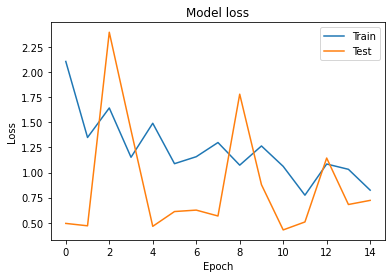

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()
plt.savefig('loss_train_val.png')

In [ ]:
loss,  mse = model.evaluate(
    [
     padded_text[80:],
     audioarr_test
    ],
    label_test,
    verbose=0,
)


In [ ]:

print("Test_loss: %f" % (loss))
print("mse_loss: %f" % (mse))

Test_loss: 0.682252
mse_loss: 0.682252
